In [11]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pandas.plotting import parallel_coordinates
import os

RECORDING_DIR = 'data_recordings/'

# Set a consistent style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 4)

In [2]:

df = pd.read_csv(RECORDING_DIR + 'manifest.csv')
df.file_path = RECORDING_DIR + df.file_path

# Files analysis 

In [3]:
print(f"Total files: {len(df)}")

# Analyze Class Balance
print("\nClass Distribution:")
class_counts = df['label'].value_counts()
print(class_counts)

Total files: 3554

Class Distribution:
label
0    1876
1    1678
Name: count, dtype: int64


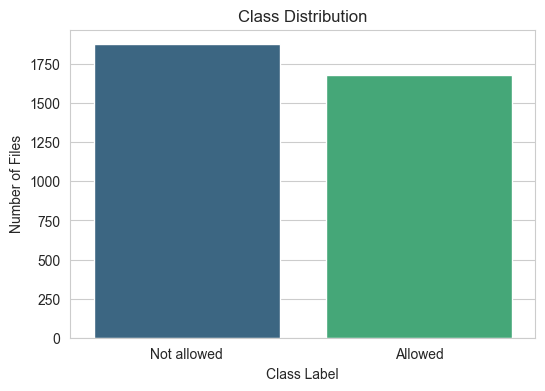

In [4]:
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df, palette='viridis', hue='label', legend=False)
plt.title('Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Number of Files')
plt.xticks([0, 1], ['Not allowed', 'Allowed'])
plt.show()

In [5]:
print("Manifest Info:")
df.info()

print("\nHead of the DataFrame:")
display(df.head())

Manifest Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3554 entries, 0 to 3553
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   speaker_id  3554 non-null   object
 1   file_path   3554 non-null   object
 2   label       3554 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 83.4+ KB

Head of the DataFrame:


,speaker_id,file_path,label
0,p231,data_recordings/rejected/p231/p231_002_000.wav,0
1,p231,data_recordings/rejected/p231/p231_003_000.wav,0
2,p231,data_recordings/rejected/p231/p231_004_000.wav,0
3,p231,data_recordings/rejected/p231/p231_005_000.wav,0
4,p231,data_recordings/rejected/p231/p231_006_000.wav,0


Total number of unique speakers: 26


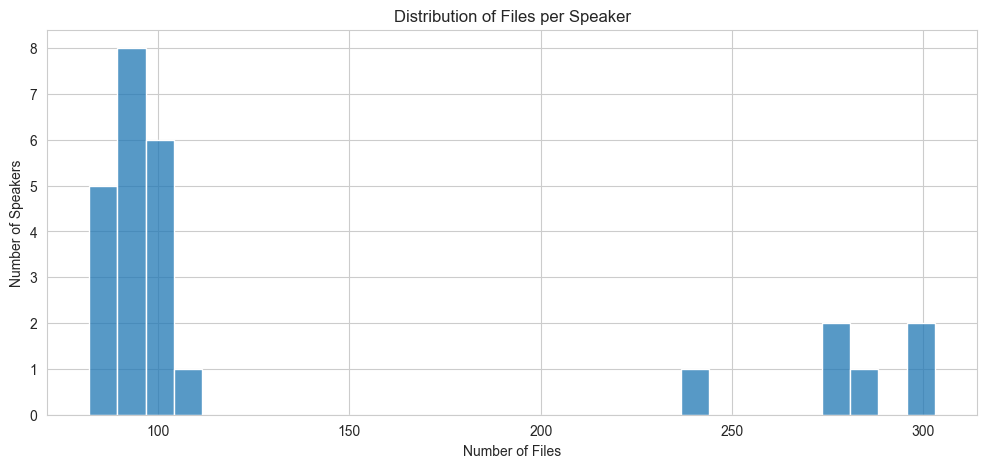


Speakers appearing in only one class: 26
Speakers appearing in both classes: 0


In [6]:
# 1. Count Speakers
num_speakers = df['speaker_id'].nunique()
print(f"Total number of unique speakers: {num_speakers}")

# 2. Files per Speaker
speaker_file_counts = df['speaker_id'].value_counts()
# print("\nFiles per speaker (Top 5):")
# print(speaker_file_counts.head())
# print("\nFiles per speaker (Bottom 5):")
# print(speaker_file_counts.tail())

plt.figure(figsize=(12, 5))
sns.histplot(speaker_file_counts, bins=30)
plt.title('Distribution of Files per Speaker')
plt.xlabel('Number of Files')
plt.ylabel('Number of Speakers')
plt.show()

# 3. Speaker-Class Overlap
speaker_labels = df.groupby('speaker_id')['label'].nunique()
print(f"\nSpeakers appearing in only one class: {(speaker_labels == 1).sum()}")
print(f"Speakers appearing in both classes: {(speaker_labels > 1).sum()}")

# Audio analysis

In [7]:
# Create lists to store extracted features
durations = []
sampling_rates = []
channels = []
rms_energies = []
spec_means = [] # Mean pixel intensity of your spectrogram
spec_stds = []  # Contrast of your spectrogram

print("Extracting features...")
for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    try:
        y, sr = librosa.load(row['file_path'])
        
        durations.append(librosa.get_duration(y=y, sr=sr))
        sampling_rates.append(sr)
        channels.append(y.shape[0] if y.ndim > 1 else 1)
        rms_energies.append(np.mean(librosa.feature.rms(y=y)))
        
        # 3. Spectrogram Stats (Using logic from your spec_image function)
        # We calculate this to see if 'Accepted' voices look different statistically
        hop_length = 512
        n_mels = 128
        mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,
                                            n_fft=hop_length*2, hop_length=hop_length)
        mels_log = np.log(mels + 1e-9)
        
        spec_means.append(np.mean(mels_log))
        spec_stds.append(np.std(mels_log))
        
    except Exception as e:
        print(f"Error with {row['file_path']}: {e}")
        durations.append(None)
        rms_energies.append(None)
        spec_means.append(None)
        spec_stds.append(None)

# Assign back to dataframe
df['duration'] = durations
df['sampling_rate'] = sampling_rates
df['channels'] = channels
df['rms_energy'] = rms_energies
df['spec_mean'] = spec_means
df['spec_std'] = spec_stds

# Drop any failed loads
df.dropna(inplace=True)

Extracting features...


100%|█████████████████████████████████████████████████████████████████████████████| 3554/3554 [00:18<00:00, 196.76it/s]



Audio Properties Analyzed:


,speaker_id,file_path,label,duration,sampling_rate,channels,rms_energy,spec_mean,spec_std
0,p231,data_recordings/rejected/p231/p231_002_000.wav,0,2.799002,22050,1,0.041134,-10.174240,5.545493
1,p231,data_recordings/rejected/p231/p231_003_000.wav,0,5.000000,22050,1,0.043358,-9.422643,5.440952
2,p231,data_recordings/rejected/p231/p231_004_000.wav,0,3.802268,22050,1,0.045894,-9.982559,5.644312
3,p231,data_recordings/rejected/p231/p231_005_000.wav,0,4.691156,22050,1,0.060161,-8.919198,5.633266
4,p231,data_recordings/rejected/p231/p231_006_000.wav,0,4.430023,22050,1,0.031713,-10.195256,5.529010



Unique Sampling Rates:
sampling_rate
22050    3554
Name: count, dtype: int64

Unique Channel Counts:
channels
1    3554
Name: count, dtype: int64


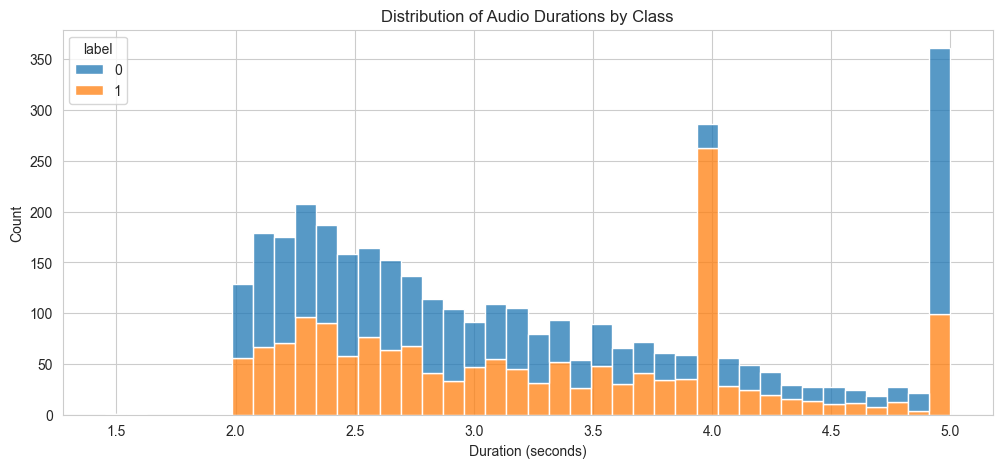

In [8]:
print("\nAudio Properties Analyzed:")
display(df.head())

# Analyze Properties
print("\nUnique Sampling Rates:")
print(df['sampling_rate'].value_counts())

print("\nUnique Channel Counts:")
print(df['channels'].value_counts())

# Plot duration
plt.figure(figsize=(12, 5))
sns.histplot(data=df, x='duration', hue='label', bins=40, multiple="stack")
plt.title(f'Distribution of Audio Durations by Class')
plt.xlabel('Duration (seconds)')
plt.show()

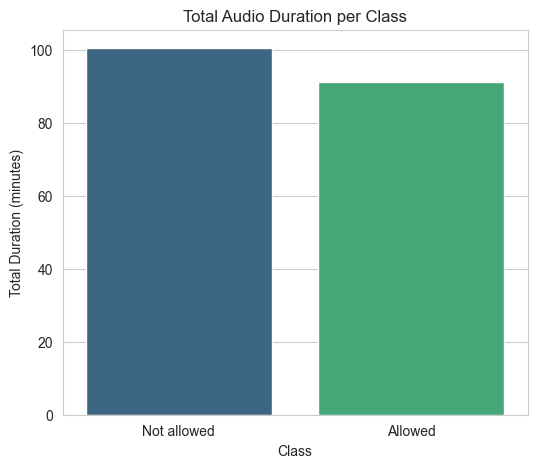

In [31]:
duration_sum = df.groupby('label')['duration'].sum().reset_index()

# (Optional) Convert to minutes for better readability if you have a lot of data
duration_sum['duration_min'] = duration_sum['duration'] / 60

# 2. Plot
plt.figure(figsize=(6, 5))
ax = sns.barplot(x='label', y='duration_min', data=duration_sum, hue='label', palette='viridis', legend=False)
plt.title('Total Audio Duration per Class')
plt.xlabel('Class')
plt.ylabel('Total Duration (minutes)')
plt.xticks([0, 1], ['Not allowed', 'Allowed'])
plt.show()

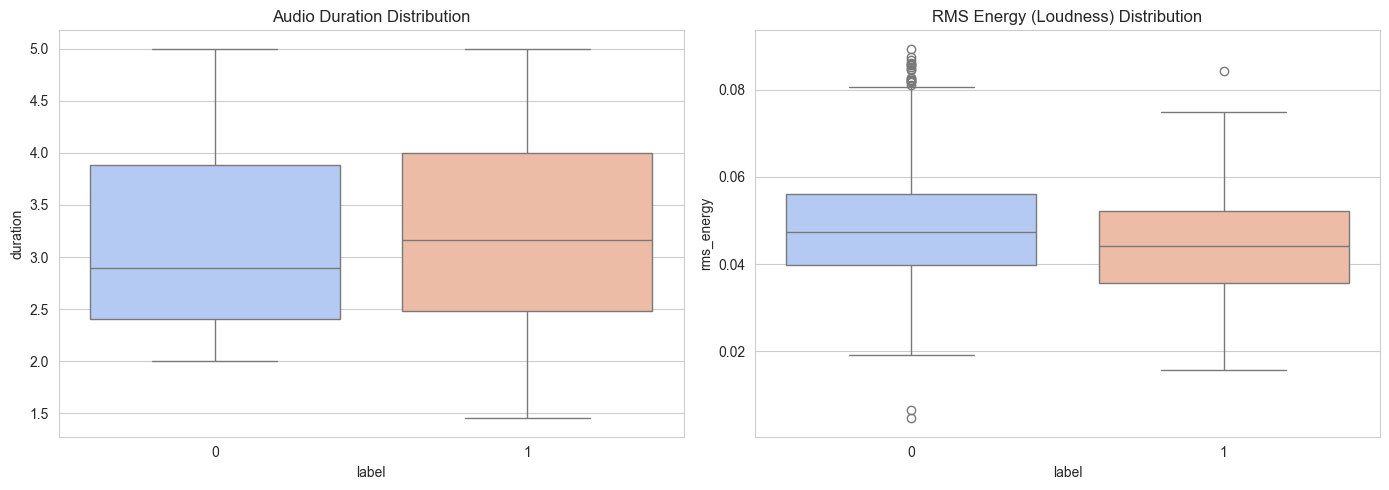

In [9]:
# Box Plots for Duration and Energy
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Duration Box Plot
sns.boxplot(x='label', y='duration', data=df, ax=axes[0], palette='coolwarm', hue='label', legend=False)
axes[0].set_title('Audio Duration Distribution')

# Energy Box Plot
sns.boxplot(x='label', y='rms_energy', data=df, ax=axes[1], palette='coolwarm', hue='label', legend=False)
axes[1].set_title('RMS Energy (Loudness) Distribution')

plt.tight_layout()
plt.show()

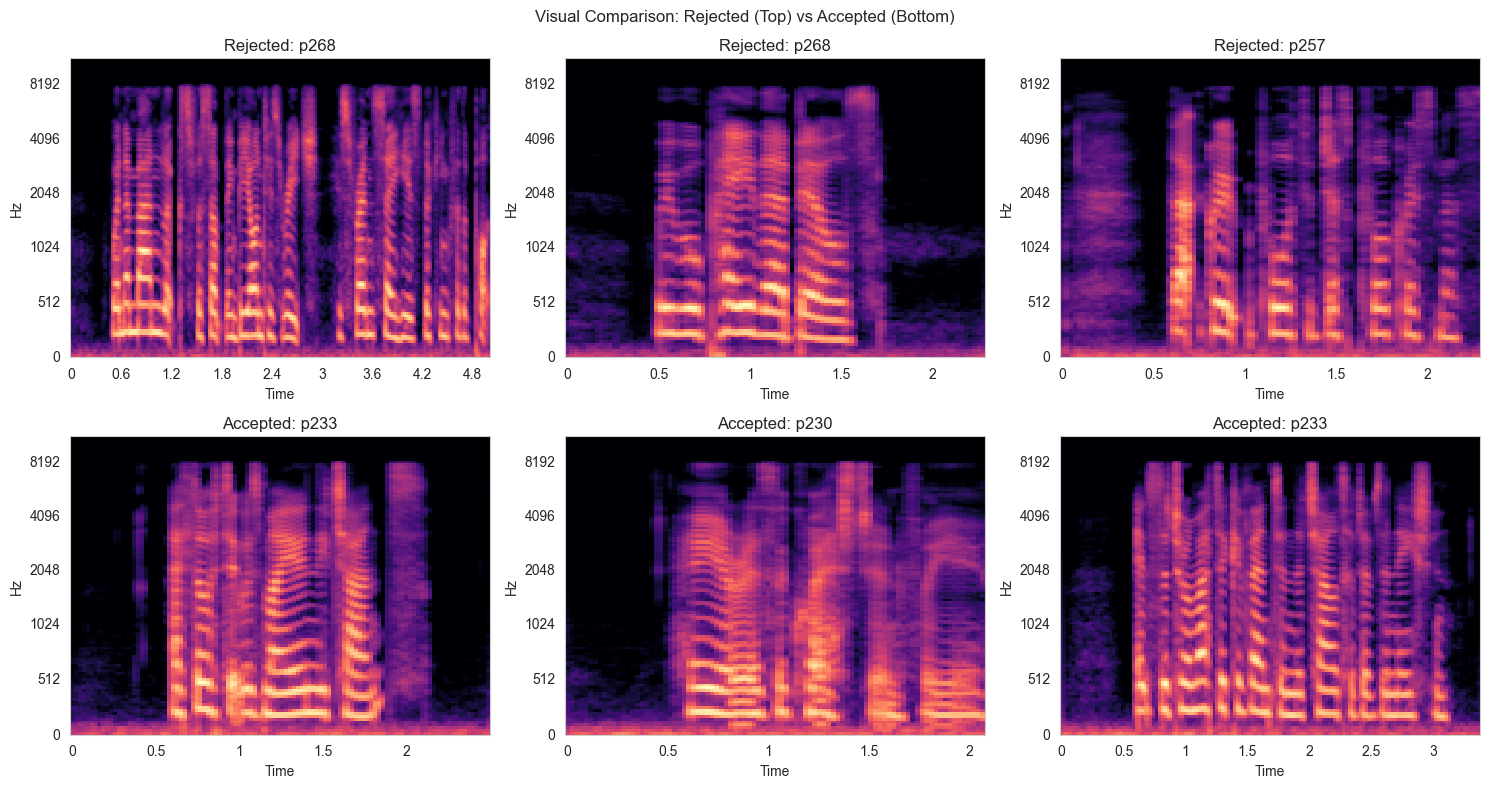

In [10]:
def custom_spec_plot(y, sr, ax, title):
    """Adapted from your spectrogram_data.py for subplotting"""
    hop_length = 512
    n_fft = 2048
    mel_signal = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=hop_length, n_fft=n_fft)
    spectrogram = np.abs(mel_signal)
    power_to_db = librosa.power_to_db(spectrogram, ref=np.max)
    
    img = librosa.display.specshow(power_to_db, sr=sr, x_axis="time", y_axis="mel", 
                                   cmap="magma", hop_length=hop_length, ax=ax)
    ax.set_title(title)
    return img

# Pick 3 random Accepted and 3 random Rejected
accepted_samples = df[df['label'] == 1].sample(3)
rejected_samples = df[df['label'] == 0].sample(3)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle("Visual Comparison: Rejected (Top) vs Accepted (Bottom)")

# Plot Rejected
for i, (_, row) in enumerate(rejected_samples.iterrows()):
    y, sr = librosa.load(row['file_path'], sr=22050)
    custom_spec_plot(y, sr, axes[0, i], f"Rejected: {row['speaker_id']}")

# Plot Accepted
for i, (_, row) in enumerate(accepted_samples.iterrows()):
    y, sr = librosa.load(row['file_path'], sr=22050)
    custom_spec_plot(y, sr, axes[1, i], f"Accepted: {row['speaker_id']}")

plt.tight_layout()
plt.show()

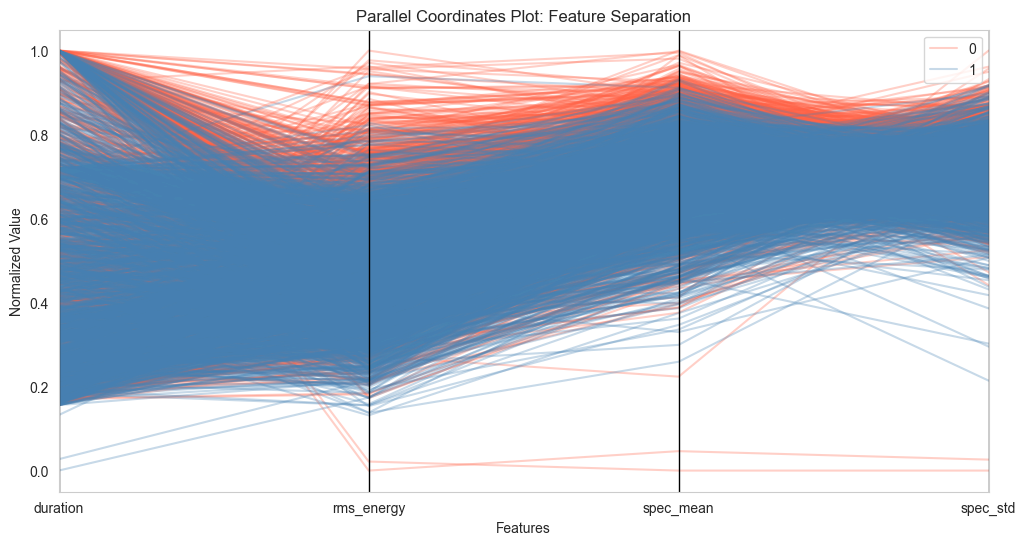

In [15]:
plot_df = df[['duration', 'rms_energy', 'spec_mean', 'spec_std', 'label']].copy()

# Min-Max normalization
for col in ['duration', 'rms_energy', 'spec_mean', 'spec_std']:
    plot_df[col] = (plot_df[col] - plot_df[col].min()) / (plot_df[col].max() - plot_df[col].min())

plt.figure(figsize=(12, 6))
parallel_coordinates(plot_df, 'label', color=('#FF6347', '#4682B4'), alpha=0.3)
plt.title('Parallel Coordinates Plot: Feature Separation')
plt.xlabel('Features')
plt.ylabel('Normalized Value')
plt.show()

Energy 5th percentile: 0.0278
Energy 95th percentile: 0.0668
Found 178 potential silent files (Outliers).


,speaker_id,file_path,label,duration,sampling_rate,channels,rms_energy,spec_mean,spec_std
16,p231,data_recordings/rejected/p231/p231_019_000.wav,0,5.000000,22050,1,0.022157,-10.453969,5.208938
49,p231,data_recordings/rejected/p231/p231_081_000.wav,0,2.624127,22050,1,0.026223,-10.800208,5.590792
50,p231,data_recordings/rejected/p231/p231_082_000.wav,0,2.183583,22050,1,0.023255,-11.632062,5.345937
68,p231,data_recordings/rejected/p231/p231_113_000.wav,0,2.473288,22050,1,0.027386,-11.845911,5.093799
97,p231,data_recordings/rejected/p231/p231_153_000.wav,0,2.151973,22050,1,0.027751,-11.260398,5.170762


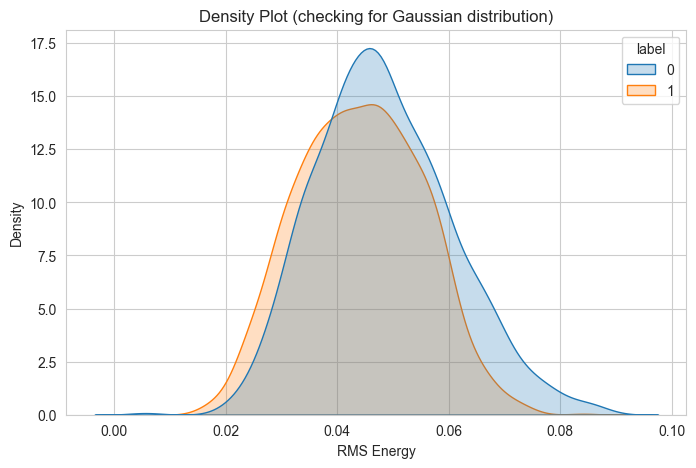

In [17]:
# Percentile-based analysis
# Calculate the 5th and 95th percentile for Energy
lower_bound = np.percentile(df['rms_energy'], 5)
upper_bound = np.percentile(df['rms_energy'], 95)

print(f"Energy 5th percentile: {lower_bound:.4f}")
print(f"Energy 95th percentile: {upper_bound:.4f}")

# Identify potential "Silent" outliers (Bottom 5% energy)
outliers = df[df['rms_energy'] < lower_bound]
print(f"Found {len(outliers)} potential silent files (Outliers).")
display(outliers.head())

# 2. Gaussian Distribution Visualization
# Check if Energy follows a Gaussian distribution
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x='rms_energy', hue='label', fill=True)
plt.title('Density Plot (checking for Gaussian distribution)')
plt.xlabel('RMS Energy')
plt.show()